## Разработка рекомендательной системы для музыки на платформе Spotify

1. Предобработка данных и EDA

Необходимо провести анализ данных (Exploratory Data Analysis, EDA) для понимания структуры датасетов и подготовки данных к разработке рекомендательной системы: 
- Загрузка данных и очистка выбросов
- Рассчитайте основные статистики для числовых колонок: среднее, медиану, стандартное отклонение, минимумы и максимумы.
- Проведите корреляционный анализ между различными признаками (например, между valence, energy, danceability и другими признаками).
- Постройте гистограммы и коробочные диаграммы для визуализации распределений числовых признаков.
- Анализ категориальных данных
- Постройте тепловую карту корреляции между признаками.

2. Разработка рекомендательной системы (Контентная фильтрация)

В этой части задания необходимо разработать рекомендательную систему, которая будет основывать свои рекомендации на характеристиках самих песен.

- Построение модели на основе контента. Используйте признаки, чтобы рекомендовать похожие песни по жанрам и стилю.
- Проведите кластеризацию для улучшения рекомендация на основе признаков с использованием алгоритмов, таких как K-means или DBSCAN. Рекомендуйте песни, которые находятся в одном кластере с уже выбранной песней.

3. Построение гибридной модели

    Разработайте гибридную рекомендательную систему, которая сочетает контентную фильтрацию и методы кластеризации признаков. Таким образом, рекомендации могут быть основаны как на схожести признаков, так и на принадлежности песен к определённым группам (кластерам).

4. Оценка качества модели

После того как модели будут построены, необходимо провести их оценку.

- Придумайте метрику для оценки качества на тренировочных данных.
- Создайте свой валидационный набор в группе студентов. Каждому из студентов необходимо выбрать по 30 песен, которые ему нравятся. Желательно разных исполнителей. Объедините данные в группе и создайте единый набор.
- Оцените свою модель с помощью метрик precision/recall at K на разных параметрах и объясните полученный результат. 

### Для начала просмотрим датасет, расшифруем признаки.

```
valence - позитивность трека. Чем ближе значение к единице, тем более трек позитивный
year - год
acousticness - акустика. Чем выше значение, тем акустичнее песня
artists - артисты
danceability - описывает пригодность дорожки для танцев на основании таких музыкальных элементов, как темп, стабильность ритма, сила долей и общее постоянство.
duration_ms - длительность_мс
energy - энергия
explicit - контент, предназначенный для взрослых, если так задумано исполнителем. У треков для взрослых будет пометка EXPLICIT или E.
id - id трека
instrumentalness - инструментальность. Прогнозирует, что в треке нет вокала. В этом контексте звуки «оу» и «а-а-а» считаются инструментальными. Рэп или треки со словами очевидно являются «вокальными». Чем ближе значение инструментальности к 1.0, тем выше вероятность того, что в треке не содержится голоса.
key - тональность
liveness - распознаёт присутствие в записи слушателей. Чем больше значения liveness, тем выше вероятность того, что песня исполнялась вживую
loudness - громкость. Измеряется каждую секунду в интервалах аудиосигнала продолжительностью в 3 секунды
mode - режим
name - название трека
popularity - популярность
release_date - дата релиза
speechiness - обнаруживает присутствие текста в песне
tempo - темп

In [4]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import sparse
from lightfm import LightFM
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import warnings

warnings.filterwarnings("ignore")



In [5]:
my_playlist = [16001, 54294, 11606, 73727, 16396, 15608, 16430, 34974, 121529, 72962, 
               55253, 17290, 106646, 12520, 15814, 17291, 15055, 15880, 122021, 9611, 
               167392, 152458, 9624, 17417, 18093, 13806, 120716, 36715, 91111, 11933,]

In [6]:
data = pd.read_csv('../HW/spotify_dataset/data/data.csv')

In [7]:
data

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055


# Эксплоративный анализ основного датасета

In [9]:
data.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [10]:
data.drop(['release_date', 'id'], axis=1, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   instrumentalness  170653 non-null  float64
 9   key               170653 non-null  int64  
 10  liveness          170653 non-null  float64
 11  loudness          170653 non-null  float64
 12  mode              170653 non-null  int64  
 13  name              170653 non-null  object 
 14  popularity        170653 non-null  int64  
 15  speechiness       170653 non-null  float64
 16  tempo             17

In [12]:
data.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


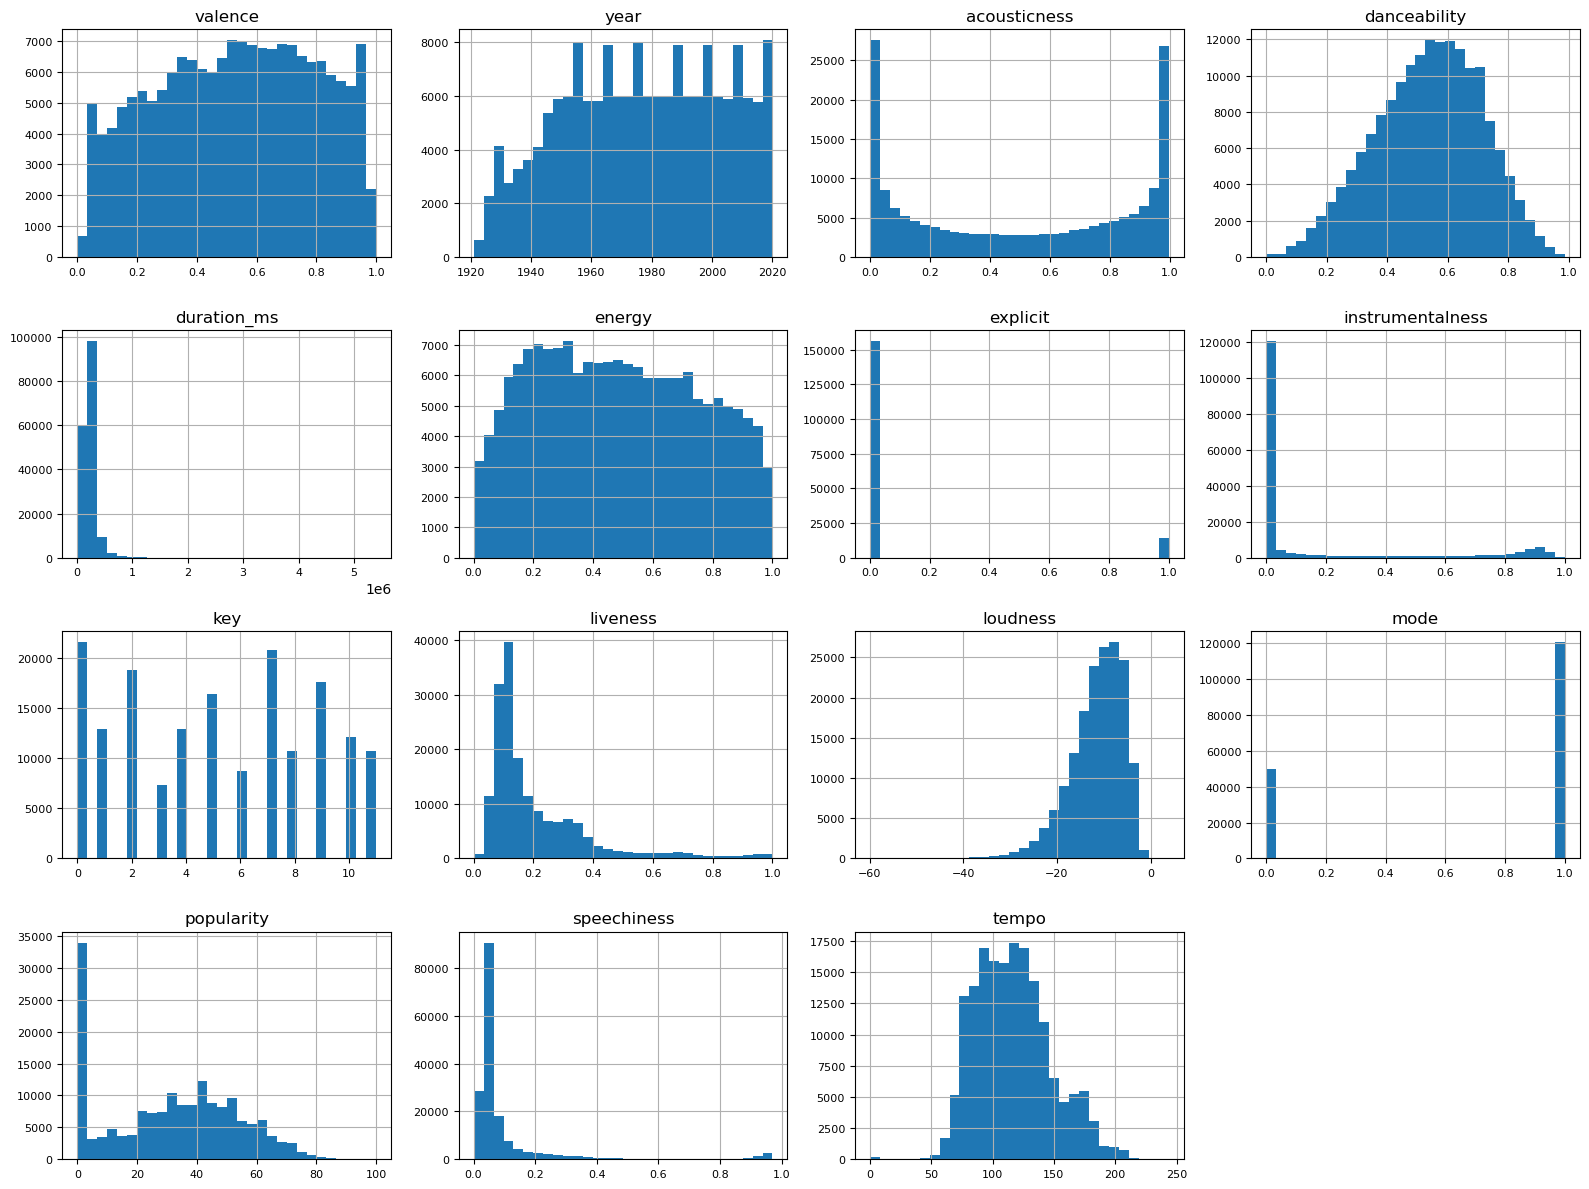

In [13]:
numerical_cols = data[data.columns[(data.dtypes == 'float64') | (data.dtypes == 'int64')]]
numerical_cols.hist(figsize=(16,12), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

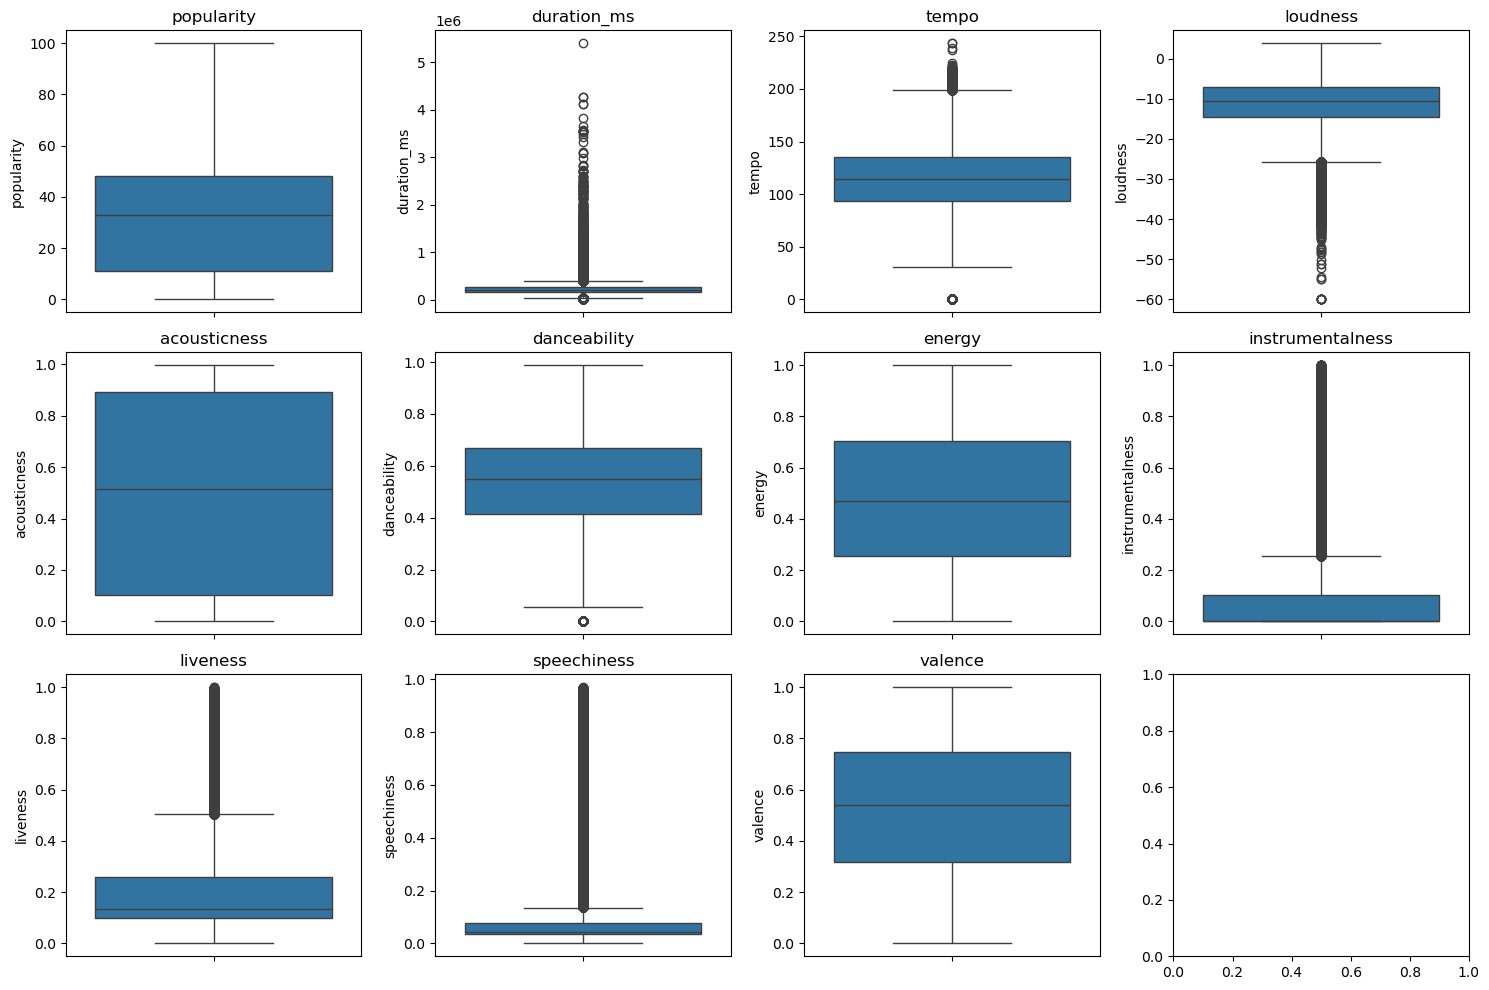

In [14]:
columns = ['popularity', 'duration_ms', 'tempo', 'loudness', 'acousticness', 'danceability', 
           'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for i, col in enumerate(columns):
    sns.boxplot(y=col, data=numerical_cols, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)
plt.tight_layout()
plt.show()

<Axes: >

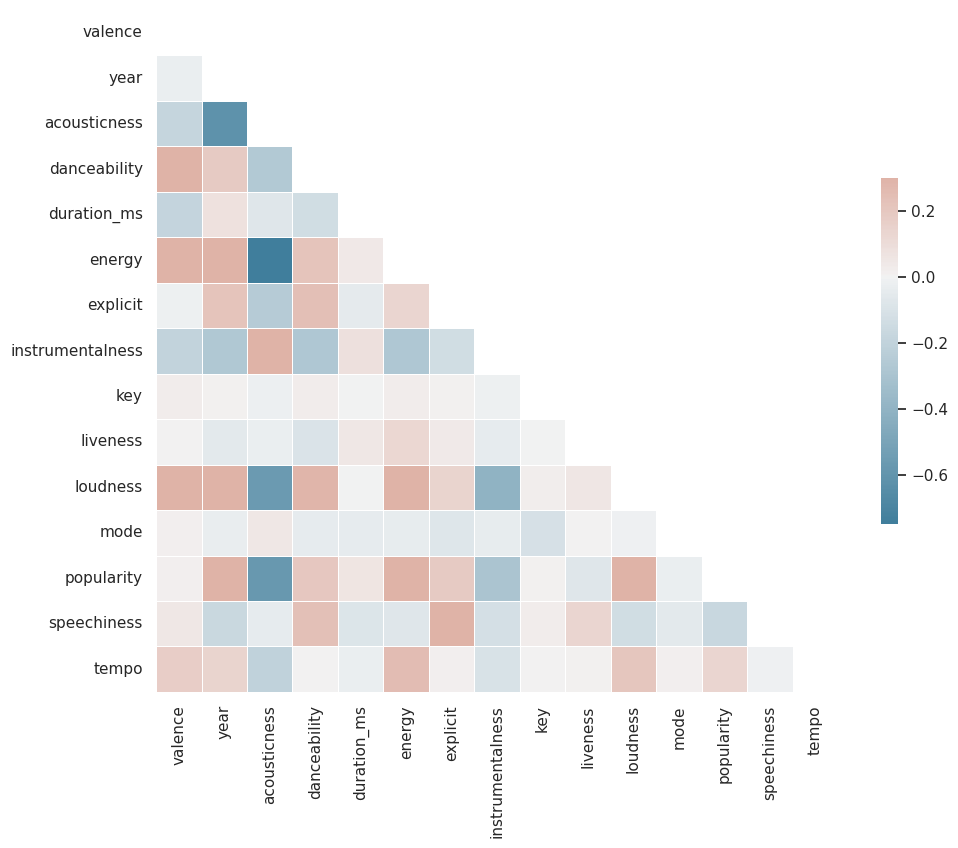

In [15]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = data.drop(['artists', 'name'], axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Краткий вывод по анализу. Пропусков в датасете нет. Несколько лишних колонок я удалил. Есть статистические выбросы, однако они имеют место быть, явных отклонений нет. Так же нет явных корреляций признаков.

# Загружаем остальные датасеты

In [18]:
data_genres = pd.read_csv('../HW/spotify_dataset/data/data_by_genres.csv')
data_genres.head()

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7


In [19]:
data_genres.describe()

,mode,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
count,2973.000000,2973.000000,2973.000000,2.973000e+03,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000,2973.000000
mean,0.833165,0.401241,0.537187,2.517209e+05,0.561143,0.211366,0.192800,-10.509848,0.083588,119.018723,0.492748,39.919185,5.938782
std,0.372891,0.319760,0.150668,9.465686e+04,0.234486,0.267329,0.092356,5.369202,0.080483,17.469188,0.201820,16.748723,3.368110
min,0.000000,0.000003,0.056900,3.094600e+04,0.001002,0.000000,0.022200,-41.825000,0.023800,47.135722,0.003353,0.000000,0.000000
25%,1.000000,0.119050,0.441202,2.063788e+05,0.395058,0.004835,0.137687,-12.427656,0.044900,109.198143,0.348578,32.491279,3.000000
50%,1.000000,0.321745,0.546496,2.375453e+05,0.601195,0.080700,0.178764,-9.221817,0.059457,119.194167,0.500048,43.056569,7.000000
75%,1.000000,0.673991,0.647500,2.772720e+05,0.730127,0.343333,0.220856,-6.920125,0.091000,127.508750,0.640257,51.138889,9.000000
max,1.000000,0.996000,0.929000,2.382587e+06,0.994667,0.992000,0.960000,0.060000,0.946219,204.212000,0.980000,80.666667,11.000000


In [20]:
data_genres_w = pd.read_csv('../HW/spotify_dataset/data/data_w_genres.csv')
data_genres_w.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [21]:
data_genres_w.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
count,28680.000000,28680.000000,2.868000e+04,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000
mean,0.498373,0.546490,2.388780e+05,0.497488,0.174756,0.202441,-11.140498,0.094014,115.844830,0.512723,34.060945,5.412901,0.759170,13.847211
std,0.370614,0.176474,1.211318e+05,0.254885,0.298406,0.140884,5.771749,0.111986,25.003834,0.244421,22.376438,3.480552,0.427595,53.372544
min,0.000000,0.000000,1.879550e+04,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.122296,0.431000,1.823304e+05,0.283568,0.000004,0.110362,-13.972292,0.039200,99.366500,0.329000,12.000000,2.000000,1.000000,2.000000
50%,0.478458,0.557000,2.186400e+05,0.504000,0.001880,0.161000,-10.088938,0.052200,115.357400,0.523243,39.000000,6.000000,1.000000,3.000000
75%,0.896000,0.675000,2.684670e+05,0.702783,0.215291,0.247000,-6.889000,0.095300,129.848750,0.703000,51.000000,8.000000,1.000000,8.000000
max,0.996000,0.986000,5.403500e+06,1.000000,1.000000,0.991000,1.342000,0.964000,217.743000,0.991000,93.000000,11.000000,1.000000,3169.000000


In [22]:
data_by_artist = pd.read_csv('../HW/spotify_dataset/data/data_by_artist.csv')
data_by_artist.head()

,mode,count,acousticness,artists,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,9,0.590111,"""Cats"" 1981 Original London Cast",0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5
1,1,26,0.862538,"""Cats"" 1983 Broadway Cast",0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5
2,1,7,0.856571,"""Fiddler On The Roof” Motion Picture Chorus",0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0
3,1,27,0.884926,"""Fiddler On The Roof” Motion Picture Orchestra",0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0
4,1,7,0.510714,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5


In [23]:
data_by_artist.describe()

,mode,count,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
count,28680.000000,28680.000000,28680.000000,28680.000000,2.868000e+04,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000,28680.000000
mean,0.759170,13.847211,0.498373,0.546490,2.388780e+05,0.497488,0.174756,0.202441,-11.140498,0.094014,115.844830,0.512723,34.060945,5.412901
std,0.427595,53.372544,0.370614,0.176474,1.211318e+05,0.254885,0.298406,0.140884,5.771749,0.111986,25.003834,0.244421,22.376438,3.480552
min,0.000000,1.000000,0.000000,0.000000,1.879550e+04,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.122296,0.431000,1.823304e+05,0.283568,0.000004,0.110362,-13.972292,0.039200,99.366500,0.329000,12.000000,2.000000
50%,1.000000,3.000000,0.478458,0.557000,2.186400e+05,0.504000,0.001880,0.161000,-10.088938,0.052200,115.357400,0.523243,39.000000,6.000000
75%,1.000000,8.000000,0.896000,0.675000,2.684670e+05,0.702783,0.215291,0.247000,-6.889000,0.095300,129.848750,0.703000,51.000000,8.000000
max,1.000000,3169.000000,0.996000,0.986000,5.403500e+06,1.000000,1.000000,0.991000,1.342000,0.964000,217.743000,0.991000,93.000000,11.000000


In [24]:
data_by_year = pd.read_csv('../HW/spotify_dataset/data/data_by_year.csv')
data_by_year.head()

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.205710,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.240720,-19.275282,0.116655,100.884521,0.535549,0.140845,10
2,1,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.389189,0
3,1,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10
4,1,1925,0.962607,0.573863,184986.924460,0.278594,0.418297,0.237668,-14.146414,0.111918,115.521921,0.621929,2.604317,5


In [25]:
data_by_year.describe()

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0000
mean,1.0,1970.500000,0.556317,0.536783,227296.752234,0.452705,0.193582,0.208224,-11.969054,0.105861,116.015674,0.532120,27.376065,3.7900
std,0.0,29.011492,0.275358,0.052356,25630.048065,0.161738,0.122488,0.017903,3.105610,0.082128,5.669645,0.057809,20.703197,3.5627
min,1.0,1921.000000,0.219931,0.414445,156881.657475,0.207948,0.016376,0.168450,-19.275282,0.049098,100.884521,0.379327,0.140845,0.0000
25%,1.0,1945.750000,0.289516,0.500800,210889.193536,0.280733,0.103323,0.197509,-14.189232,0.064244,111.718626,0.497174,3.298200,0.0000
50%,1.0,1970.500000,0.459190,0.540976,235520.850833,0.495997,0.127644,0.206074,-11.773061,0.085763,117.455548,0.541503,33.619250,2.0000
75%,1.0,1995.250000,0.856711,0.570948,247702.738058,0.598008,0.276707,0.218493,-9.950542,0.104438,120.606644,0.570080,44.943375,7.0000
max,1.0,2020.000000,0.962607,0.692904,267677.823086,0.681778,0.581701,0.264335,-6.595067,0.490001,124.283129,0.663725,65.256542,10.0000


# Делаем рекомендацию по характеристикам песни
### Пробуем использовать корреляцию входной песни с остальными песнями в ДатаСете

In [27]:
class RecomendationBySongFeatures():
    def __init__(self, main_data):
        self.main_data = main_data 
        self.minmaxscl = MinMaxScaler()

    @staticmethod
    def correletion(row, target):
        return row.T.corr(target)

    def songs_by_main_data(self, song_ind):
        use_data = self.main_data.drop(['artists', 'name', 'year', 'duration_ms', 'popularity'], axis=1)
        use_data[['key', 'loudness', 'tempo']] = self.minmaxscl.fit_transform(use_data[['key', 'loudness', 'tempo']])
        song_sim_ind = use_data.T.apply(lambda x: self.correletion(x, use_data.loc[song_ind])).sort_values(ascending=False).head(1000)
        song_sim_ind = song_sim_ind.loc[song_sim_ind.values < 0.999999999999999].index
        return song_sim_ind

In [28]:
rec = RecomendationBySongFeatures(main_data=data)
song_i = rec.songs_by_main_data(152458)

In [29]:
data.loc[song_i].head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo
123839,0.1240,2015,0.010500,['Joseph Merk'],0.566,457056,0.958,0,0.894,10,0.352,-5.947,0,Renovation - Original Mix,0,0.0705,138.003
153968,0.0376,2013,0.001460,['Shogun'],0.588,220091,0.961,0,0.843,9,0.337,-3.952,0,UFO,0,0.0482,131.022
155221,0.0893,2019,0.000122,['Genix'],0.542,271628,0.970,0,0.841,11,0.414,-6.328,0,Open Your Eyes,2,0.0441,129.009
64767,0.1780,1968,0.030700,"['Bernard ""Pretty"" Purdie']",0.446,209667,0.988,0,0.817,11,0.131,-8.169,0,Soul Drums,32,0.0801,122.408
152984,0.2790,2007,0.002970,['Justice'],0.518,298587,0.932,0,0.881,10,0.268,-4.854,0,Stress,47,0.1340,126.940


Работает долго, рекомендации сомнительные

### Попробуем применить косинусное сходство

In [32]:
class RecomendationBySongFeaturesCosSim():
    def __init__(self, main_data):
        self.main_data = main_data 
        self.minmaxscl = MinMaxScaler()
        self.vectorizer = DictVectorizer(sparse=False)
        
    def songs_by_main_data(self, song_ind):
        
        use_data = self.main_data.drop(['artists', 'name', 'year', 'duration_ms', 'popularity'], axis=1)
        use_data_scaled = self.minmaxscl.fit_transform(use_data)
        vector_data = [{use_data.columns[key]: value for key, value in enumerate(song)} for song in use_data_scaled]
        
        transformed_data = self.vectorizer.fit_transform(vector_data)
    
        result = cosine_similarity(transformed_data, transformed_data[song_ind].reshape(1, -1))
        result = pd.DataFrame(result).sort_values(by=0, ascending=False).head(1000).index
        return result

In [33]:
rec_cos_sim = RecomendationBySongFeaturesCosSim(main_data=data)
song_i_cos_sim = rec_cos_sim.songs_by_main_data(152458)

In [34]:
data.loc[song_i_cos_sim].head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo
152458,0.0803,2004,0.000328,['In Flames'],0.509,278653,0.959,0,0.832,10,0.237,-5.578,0,My Sweet Shadow,49,0.0694,119.782
123839,0.1240,2015,0.010500,['Joseph Merk'],0.566,457056,0.958,0,0.894,10,0.352,-5.947,0,Renovation - Original Mix,0,0.0705,138.003
153968,0.0376,2013,0.001460,['Shogun'],0.588,220091,0.961,0,0.843,9,0.337,-3.952,0,UFO,0,0.0482,131.022
155221,0.0893,2019,0.000122,['Genix'],0.542,271628,0.970,0,0.841,11,0.414,-6.328,0,Open Your Eyes,2,0.0441,129.009
64767,0.1780,1968,0.030700,"['Bernard ""Pretty"" Purdie']",0.446,209667,0.988,0,0.817,11,0.131,-8.169,0,Soul Drums,32,0.0801,122.408


Применили косинусное сходство, считает быстрее, благодоря тому, что для расчёта датасет был переведён в numpy array, но сам результат такой же как и с корреляцией

### Теперь возьмём песню и попробуем составить рекомендацию опираясь на жанр и исполнителя

# Примечание
в данном блоке я использовал функцию eval(). Я знаю, что эту функцию применять стоит с опаской, так как это функция использует строку как код, но в данном случае я использую её не для ввода с клавиатуры и я не придумал ничего лучше, что бы применить эту функцию для распаковки жанров из датасета, которые записаны как строка-список

In [38]:
class Recomendation():
    def __init__(self, main_data, geners_artist_data, data_by_artist):
        self.main_data = main_data
        self.geners_artist_data = geners_artist_data
        self.data_by_artist = data_by_artist
        self.scaler = MinMaxScaler()
        self.vectorizer = DictVectorizer(sparse=False)

    @staticmethod
    def exploration_mask(target_data, exploration_data):
        similer_dict = {ind: value for ind, value in enumerate(exploration_data) if set(target_data) & set(eval(value))}
        return similer_dict.keys()

    def make_data_by_gener(self, index):
        artist = eval(self.main_data.loc[index]['artists'])[0]
        geners_list = eval(self.geners_artist_data.loc[self.geners_artist_data['artists'] == artist]['genres'].item())
        similar_artists_by_gener = self.geners_artist_data.loc[self.exploration_mask(geners_list, data_genres_w['genres'])]['artists'].tolist()
        similar_artist_data = self.main_data.loc[self.exploration_mask(similar_artists_by_gener, self.main_data['artists'])]
        return similar_artist_data

    def recomendation(self, index, is_for_knn=False, make_d_by_gender=True):
        if make_d_by_gender:
            data = self.make_data_by_gener(index)
            data.reset_index(inplace=True)
            index = data.loc[data['index']==index].index
            cleared_data = data.drop(['index', 'artists', 'duration_ms', 'name', 'popularity'], axis=1)
        else:
            data = self.main_data
            cleared_data = data.drop(['artists', 'duration_ms', 'name', 'popularity'], axis=1)
        norm_data = self.scaler.fit_transform(cleared_data)
        vector_data = [{cleared_data.columns[key]: value for key, value in enumerate(song)} for song in norm_data]
        transformed_data = self.vectorizer.fit_transform(vector_data)
        result = cosine_similarity(transformed_data, transformed_data[index].reshape(1, -1))
        result = pd.DataFrame(result).sort_values(by=0, ascending=False)
        if not is_for_knn:
            result = result.loc[result.values < 0.99999999999999]
        return data.loc[result.index]

    def artist_recomendation(self, index, is_for_knn=False):
        artist = eval(self.main_data.loc[index]['artists'])[0]
        new_ind = data_by_artist.loc[data_by_artist['artists'] == artist].index
        cleared_data = data_by_artist.drop(['artists', 'duration_ms', 'popularity'], axis=1)
        norm_data = self.scaler.fit_transform(cleared_data)
        vector_data = [{cleared_data.columns[key]: value for key, value in enumerate(artist)} for artist in norm_data]
        transformed_data = self.vectorizer.fit_transform(vector_data)
        result = cosine_similarity(transformed_data, transformed_data[new_ind].reshape(1, -1))
        result = pd.DataFrame(result).sort_values(by=0, ascending=False)
        if not is_for_knn:
            result = result.loc[result.values < 0.99999999999999]
        
        return self.data_by_artist.loc[result.index]
        

Данные рекомендации уже немного лучше, подбирает более менее схожее, отберём какое то количество песен и посмотрим входят ли песни из моего отобранного плейлиста в данный список по одной песне

In [40]:
rec = Recomendation(main_data=data, geners_artist_data=data_genres_w, data_by_artist=data_by_artist)
ammount_of_songs_cos_sim = 2000
len_target = len(my_playlist) - 1
catch_collection_cos_sim = []

for it, song in enumerate(my_playlist, 1):
    rest_of_playlist = my_playlist.copy()
    rest_of_playlist.remove(song)
    my_recomendation = rec.recomendation(song, make_d_by_gender=False).head(ammount_of_songs_cos_sim)
    catch = set(my_recomendation.index) & set(rest_of_playlist)
    try:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {round((100 * len(catch)) / len_target, 1):04}%')
    except ZeroDivisionError:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {0.00:04}%')
    catch_collection_cos_sim.append(len(catch))

cos_sim_accurasy = round((100 * (sum(catch_collection_cos_sim)/len(catch_collection_cos_sim))) / len(my_playlist), 1)
print()
print(f'Средний показатель попаданий на {ammount_of_songs_cos_sim} треков: {cos_sim_accurasy}%')

Тест № 1: Композиция  16001. Успешное попадание из 2000 рекомендованных песен: 29/3, 10.3%
Тест № 2: Композиция  54294. Успешное попадание из 2000 рекомендованных песен: 29/2, 06.9%
Тест № 3: Композиция  11606. Успешное попадание из 2000 рекомендованных песен: 29/0, 00.0%
Тест № 4: Композиция  73727. Успешное попадание из 2000 рекомендованных песен: 29/1, 03.4%
Тест № 5: Композиция  16396. Успешное попадание из 2000 рекомендованных песен: 29/2, 06.9%
Тест № 6: Композиция  15608. Успешное попадание из 2000 рекомендованных песен: 29/2, 06.9%
Тест № 7: Композиция  16430. Успешное попадание из 2000 рекомендованных песен: 29/2, 06.9%
Тест № 8: Композиция  34974. Успешное попадание из 2000 рекомендованных песен: 29/2, 06.9%
Тест № 9: Композиция 121529. Успешное попадание из 2000 рекомендованных песен: 29/1, 03.4%
Тест №10: Композиция  72962. Успешное попадание из 2000 рекомендованных песен: 29/1, 03.4%
Тест №11: Композиция  55253. Успешное попадание из 2000 рекомендованных песен: 29/1, 03.4%

In [41]:
rec_g = Recomendation(main_data=data, geners_artist_data=data_genres_w, data_by_artist=data_by_artist)
ammount_of_songs_cos_sim_g = 2000
len_target = len(my_playlist) - 1
catch_collection_cos_sim_g = []

for it, song in enumerate(my_playlist, 1):
    rest_of_playlist = my_playlist.copy()
    rest_of_playlist.remove(song)
    my_recomendation = rec_g.recomendation(song).head(ammount_of_songs_cos_sim_g)
    catch = set(my_recomendation['index'].values) & set(rest_of_playlist)
    try:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {round((100 * len(catch)) / len_target, 1):04}%')
    except ZeroDivisionError:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {0.00:04}%')
    catch_collection_cos_sim_g.append(len(catch))

cos_sim_g_accurasy = round((100 * (sum(catch_collection_cos_sim_g)/len(catch_collection_cos_sim_g))) / len(my_playlist), 1)
print()
print(f'Средний показатель попаданий на {ammount_of_songs_cos_sim_g} треков: {cos_sim_g_accurasy}%')

Тест № 1: Композиция  16001. Успешное попадание из 2000 рекомендованных песен: 29/16, 55.2%
Тест № 2: Композиция  54294. Успешное попадание из 2000 рекомендованных песен: 29/9, 31.0%
Тест № 3: Композиция  11606. Успешное попадание из 2000 рекомендованных песен: 29/1, 03.4%
Тест № 4: Композиция  73727. Успешное попадание из 2000 рекомендованных песен: 29/13, 44.8%
Тест № 5: Композиция  16396. Успешное попадание из 2000 рекомендованных песен: 29/7, 24.1%
Тест № 6: Композиция  15608. Успешное попадание из 2000 рекомендованных песен: 29/14, 48.3%
Тест № 7: Композиция  16430. Успешное попадание из 2000 рекомендованных песен: 29/11, 37.9%
Тест № 8: Композиция  34974. Успешное попадание из 2000 рекомендованных песен: 29/6, 20.7%
Тест № 9: Композиция 121529. Успешное попадание из 2000 рекомендованных песен: 29/13, 44.8%
Тест №10: Композиция  72962. Успешное попадание из 2000 рекомендованных песен: 29/2, 06.9%
Тест №11: Композиция  55253. Успешное попадание из 2000 рекомендованных песен: 29/6, 

И всё же рекомендации по песням оказались не очень то и хороши, можно так же попробовать предиктить не песни, а исполнителя.

In [43]:
artists_list = []
for i in range(len(rest_of_playlist)):
    artist = eval(data.loc[rest_of_playlist]['artists'].values.tolist()[i])[0]
    artists_list.append(artist)

In [44]:
ammount_of_artists = 1000
len_target = len(my_playlist) - 1
catch_collection_artists = []

for it, song in enumerate(my_playlist, 1):
    rest_of_playlist = my_playlist.copy()
    rest_of_playlist.remove(song)
    my_recomendation_of_artists = rec.artist_recomendation(song).head(ammount_of_artists)
    catch = set(my_recomendation_of_artists['artists'].values) & set(artists_list)
    try:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation_of_artists)} '
        f'рекомендованных исполнителей: {len_target}/{len(catch)}, {round((100 * len(catch) / len_target), 1):04}%')
    except ZeroDivisionError:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation_of_artists)} '
        f'рекомендованных исполнителей: {len_target}/{len(catch)}, {0.00:04}%')
    catch_collection_artists.append(len(catch))

print(f'Средний показатель попаданий на {ammount_of_artists} исполнителей: '
f'{round((100 * (sum(catch_collection_artists)/len(catch_collection_artists))) / len(my_playlist))}%')

Тест № 1: Композиция  16001. Успешное попадание из 1000 рекомендованных исполнителей: 29/8, 27.6%
Тест № 2: Композиция  54294. Успешное попадание из 1000 рекомендованных исполнителей: 29/9, 31.0%
Тест № 3: Композиция  11606. Успешное попадание из 1000 рекомендованных исполнителей: 29/8, 27.6%
Тест № 4: Композиция  73727. Успешное попадание из 1000 рекомендованных исполнителей: 29/7, 24.1%
Тест № 5: Композиция  16396. Успешное попадание из 1000 рекомендованных исполнителей: 29/6, 20.7%
Тест № 6: Композиция  15608. Успешное попадание из 1000 рекомендованных исполнителей: 29/8, 27.6%
Тест № 7: Композиция  16430. Успешное попадание из 1000 рекомендованных исполнителей: 29/7, 24.1%
Тест № 8: Композиция  34974. Успешное попадание из 1000 рекомендованных исполнителей: 29/6, 20.7%
Тест № 9: Композиция 121529. Успешное попадание из 1000 рекомендованных исполнителей: 29/1, 03.4%
Тест №10: Композиция  72962. Успешное попадание из 1000 рекомендованных исполнителей: 29/6, 20.7%
Тест №11: Композиция

### Попробуем использовать KNN

In [46]:
class KNNRecommendation():
    def __init__(self, data, neighbors=5):
        self.data = data
        self.scaler = MinMaxScaler()
        self.features = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 
                        'liveness', 'speechiness', 'instrumentalness']
        self.k_neigbors = neighbors
        self.knn_model = NearestNeighbors(n_neighbors=self.k_neigbors, metric='cosine')

    def recomendation(self, index, n_recomendations=1000):
        normalized_features = self.scaler.fit_transform(self.data[self.features])
        self.knn_model.fit(normalized_features)
        
        if 'index' in self.data:
            index = self.data[self.data['index']==index].index[0]

        _, indices = self.knn_model.kneighbors([normalized_features[index]], n_neighbors=n_recomendations + 1)
        recommendations = self.data.iloc[indices[0]]
        return recommendations

In [47]:
ammount_of_songs_knn = 2000
len_target = len(my_playlist) - 1
catch_collection_knn = []

knn_rec = KNNRecommendation(data=data)

for it, song in enumerate(my_playlist, 1):
    rest_of_playlist = my_playlist.copy()
    rest_of_playlist.remove(song)
    my_recomendation = knn_rec.recomendation(song, ammount_of_songs_knn)
    catch = set(my_recomendation.index) & set(rest_of_playlist)
    try:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {round((100 * len(catch)) / len_target, 1):04}%')
    except ZeroDivisionError:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {0.00:04}%')
    catch_collection_knn.append(len(catch))

knn_rec_accurasy = round((100 * (sum(catch_collection_knn)/len(catch_collection_knn))) / len(my_playlist), 1)
print()
print(f'Средний показатель попаданий на {ammount_of_songs_knn} треков: {knn_rec_accurasy}%')

Тест № 1: Композиция  16001. Успешное попадание из 2001 рекомендованных песен: 29/4, 13.8%
Тест № 2: Композиция  54294. Успешное попадание из 2001 рекомендованных песен: 29/3, 10.3%
Тест № 3: Композиция  11606. Успешное попадание из 2001 рекомендованных песен: 29/1, 03.4%
Тест № 4: Композиция  73727. Успешное попадание из 2001 рекомендованных песен: 29/1, 03.4%
Тест № 5: Композиция  16396. Успешное попадание из 2001 рекомендованных песен: 29/2, 06.9%
Тест № 6: Композиция  15608. Успешное попадание из 2001 рекомендованных песен: 29/3, 10.3%
Тест № 7: Композиция  16430. Успешное попадание из 2001 рекомендованных песен: 29/2, 06.9%
Тест № 8: Композиция  34974. Успешное попадание из 2001 рекомендованных песен: 29/3, 10.3%
Тест № 9: Композиция 121529. Успешное попадание из 2001 рекомендованных песен: 29/0, 00.0%
Тест №10: Композиция  72962. Успешное попадание из 2001 рекомендованных песен: 29/0, 00.0%
Тест №11: Композиция  55253. Успешное попадание из 2001 рекомендованных песен: 29/3, 10.3%

При помощи КНН добились неплохих результатов, учитывая, что мы использовали весь датасет. А теперь попробуем предворительно отобрать датасет на основе артистов и жанров и посмотреть результат на отобранном датасете

In [49]:
len_target = len(my_playlist) - 1
catch_collection_knn_cos_sim = []
rec = Recomendation(main_data=data, geners_artist_data=data_genres_w, data_by_artist=data_by_artist)
ammount_of_songs_knn_cos_sim = 2000
for it, song in enumerate(my_playlist, 1):
    rest_of_playlist = my_playlist.copy()
    rest_of_playlist.remove(song)
    new_data = rec.recomendation(song, is_for_knn=True)
    knn_rec = KNNRecommendation(data=new_data, neighbors=3)
    my_recomendation = knn_rec.recomendation(song, ammount_of_songs_knn_cos_sim)
    catch = set(my_recomendation['index'].values) & set(rest_of_playlist)
    
    try:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {round((100 * len(catch)) / len_target, 1):04}%')
    except ZeroDivisionError:
        print(f'Тест №{it:>2}: Композиция {song:>6}. Успешное попадание из {len(my_recomendation)} рекомендованных песен: '
        f'{len_target}/{len(catch)}, {0.00:04}%')
    catch_collection_knn_cos_sim.append(len(catch))

knn_cos_sim_accurasy = round((100 * (sum(catch_collection_knn_cos_sim)/len(catch_collection_knn_cos_sim))) / len(my_playlist), 1)
print()
print(f'Средний показатель попаданий на {ammount_of_songs_knn_cos_sim} треков: {knn_cos_sim_accurasy}%')

Тест № 1: Композиция  16001. Успешное попадание из 2001 рекомендованных песен: 29/11, 37.9%
Тест № 2: Композиция  54294. Успешное попадание из 2001 рекомендованных песен: 29/10, 34.5%
Тест № 3: Композиция  11606. Успешное попадание из 2001 рекомендованных песен: 29/1, 03.4%
Тест № 4: Композиция  73727. Успешное попадание из 2001 рекомендованных песен: 29/8, 27.6%
Тест № 5: Композиция  16396. Успешное попадание из 2001 рекомендованных песен: 29/9, 31.0%
Тест № 6: Композиция  15608. Успешное попадание из 2001 рекомендованных песен: 29/8, 27.6%
Тест № 7: Композиция  16430. Успешное попадание из 2001 рекомендованных песен: 29/10, 34.5%
Тест № 8: Композиция  34974. Успешное попадание из 2001 рекомендованных песен: 29/6, 20.7%
Тест № 9: Композиция 121529. Успешное попадание из 2001 рекомендованных песен: 29/9, 31.0%
Тест №10: Композиция  72962. Успешное попадание из 2001 рекомендованных песен: 29/5, 17.2%
Тест №11: Композиция  55253. Успешное попадание из 2001 рекомендованных песен: 29/8, 27

Итак. Подведём некоторые итоги

In [51]:
print(f'1) РекСистема основана на косинусном сходстве. '
f'Количество песен: {ammount_of_songs_cos_sim}. '
f'Точноть предсказания на выборке: {cos_sim_accurasy}%')
print()

print(f'2) РекСистема основана на KNN и всём датасете. '
f'Количество соседей: {ammount_of_songs_knn}. '
f'Точноть предсказания на выборке: {knn_rec_accurasy}%')
print()

print(f'3) РекСистема основана на косинусном сходстве с учётом жанра. '
f'Количество песен: {ammount_of_songs_cos_sim_g}. '
f'Точноть предсказания на выборке: {cos_sim_g_accurasy}%')
print()

print(f'4) РекСистема, отбирает датасет со схожими жанрами для каждой песни и затем KNN выбирает похожие среди них.\n'
f'Количество песен: {ammount_of_songs_cos_sim}. '
f'Точноть предсказания на выборке: {knn_cos_sim_accurasy}%')


1) РекСистема основана на косинусном сходстве. Количество песен: 2000. Точноть предсказания на выборке: 5.2%

2) РекСистема основана на KNN и всём датасете. Количество соседей: 2000. Точноть предсказания на выборке: 5.7%

3) РекСистема основана на косинусном сходстве с учётом жанра. Количество песен: 2000. Точноть предсказания на выборке: 22.7%

4) РекСистема, отбирает датасет со схожими жанрами для каждой песни и затем KNN выбирает похожие среди них.
Количество песен: 2000. Точноть предсказания на выборке: 21.4%


Оценка рекомендательной системы следующая, назначаем размер выборки рекомендации, в нашем случае это 2000 песен, и смотрим сколько песен из нашей выборки попала в указанный интервал.

В данном случае КНН не улучшает наши показатели, даже наоборот, хотя при других значениях количества песен ситуация разная, где то есть улучшения, где то ухудшения. Хотя без отбора по жанру срабатывает лучше и значительно быстрее. Так же стоит отметить более ровную работу KNN, в то время как рек система на основе косинусного сходства прыгает от 0 до 55% предсказаний, на 2000 песен; рек система основана на отборе по жанру и KNN срабатывает более ровно и крутится в райне 20-30%

# РекСистема на основе LightFM

```
нужно отметить, что я ставил LightFM на Python 3.12. 
пользовался обновлением:
pip install git+https://github.com/daviddavo/lightfm

In [55]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import sparse
from lightfm import LightFM
from lightfm.data import Dataset
import random

from sklearn.metrics.pairwise import cosine_similarity

In [56]:
validation_data = pd.read_csv('../HW/spotify_dataset/data/users_preference_data.csv')
validation_data = validation_data.rename(columns={'Unnamed: 0': 'old_index'})

In [57]:
def validation_split(validation_data):
    users_dict = {}
    
    for user_id in validation_data['user_ID'].unique():
        users_dict[user_id] = list(validation_data.loc[validation_data['user_ID'] == user_id]['old_index'])
    return users_dict

In [58]:
users_dict = validation_split(validation_data)

In [59]:
for user, ind in users_dict.items():
    data.loc[ind, 'user_ind'] = user

In [60]:
data['user_ind'].value_counts()

user_ind
2.0     34
4.0     30
5.0     30
8.0     30
10.0    30
3.0     30
1.0     30
9.0     30
7.0     29
6.0     29
Name: count, dtype: int64

In [61]:
def create_interaction_matrix(df,user_col, item_col, in_data, norm= False, threshold = None):
    interactions = df.groupby([user_col, item_col])[in_data] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [62]:
interactions = create_interaction_matrix(data, 'user_ind', data.index, 'popularity')

In [63]:
interactions

,17491,17730,50264,50801,52026,66550,66692,67718,67857,82033,...,55253,72962,73727,91111,106646,120716,121529,122021,152458,167392
user_ind,,,,,,,,,,,,,,,,,,,,,
1.0,71.0,69.0,51.0,44.0,62.0,32.0,37.0,41.0,42.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
def create_user_dict(interactions):
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [65]:
user_dict = create_user_dict(interactions=interactions)

In [66]:
def create_item_dict(data):
    item_dict ={}
    for i in range(data.shape[0]):
        item_dict[i] = f'{eval(data.loc[i,'artists'])} - {data.loc[i,'name']}'
    return item_dict

In [67]:
songs_dict = create_item_dict(data)

In [68]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30, n_jobs = 4):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components=n_components, loss=loss, k=k)
    model.fit(x, epochs=epoch, num_threads=n_jobs)
    return model

In [69]:
mf_model = runMF(interactions = interactions,
                 n_components = 30,
                 loss = 'warp',
                 k =15,
                 epoch = 30,
                 n_jobs = 4)

In [70]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict,threshold = 0,nrec_items = 10, show = True):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    # Предсказываем рейтинги для всех товаров для данного пользователя
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    # Присваиваем индексам товаров предсказанные оценки
    scores.index = interactions.columns
    # Сортируем товары по убыванию предсказанных оценок
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    # Получаем список товаров, с которыми пользователь уже взаимодействовал (и их оценка выше порога)
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))

    # Исключаем известные товары из списка рекомендаций
    scores = [x for x in scores if x not in known_items]

    # Возвращаем топ-товаров
    return_score_list = scores[0:nrec_items]
    # Преобразуем товары в их названия
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list

In [71]:
rec_list = sample_recommendation_user(model = mf_model,
                                      interactions = interactions,
                                      user_id = 10,
                                      user_dict = user_dict,
                                      item_dict = songs_dict,
                                      threshold = 0,
                                      nrec_items = 50)

Known Likes:
1- ['Finntroll'] - Trollhammaren
2- ['In Flames'] - My Sweet Shadow
3- ['Poets of the Fall'] - Carnival of Rust
4- ['Element Eighty'] - Broken Promises
5- ['Children Of Bodom'] - Downfall
6- ['Korpiklaani'] - Vodka
7- ['Nonpoint'] - Breaking Skin
8- ['Five Finger Death Punch'] - M.I.N.E (End This Way)
9- ['Billy Talent'] - Rusted From the Rain
10- ['The Pretty Reckless'] - Make Me Wanna Die
11- ['Avenged Sevenfold'] - Blinded in Chains
12- ['Sabaton'] - Primo Victoria
13- ['Disturbed'] - Prayer
14- ['Thousand Foot Krutch'] - Courtesy Call
15- ['Skillet'] - Monster
16- ['Volbeat'] - Still Counting
17- ['Hollywood Undead'] - Everywhere I Go
18- ['Slipknot'] - Before I Forget
19- ['Static-X'] - The Only
20- ['Rammstein'] - Sonne
21- ['Dope'] - Die MF Die
22- ['System Of A Down'] - Toxicity
23- ['Linkin Park'] - In the End
24- ['Metallica'] - Fuel
25- ['Nirvana'] - Smells Like Teen Spirit
26- ['Scorpions'] - Still Loving You
27- ['Queen'] - Another One Bites The Dust
28- ['AC/

К сожалению для того, что бы ориентироваться на пользователей для рекомендаций, слишком маленький датасет понравившихся песен. В данном случае я ориентировался на других пользователей и рейтинг песен.

# Собственная РекСистема
В данном блоке я пробую создать РекСистему основанную на предпочтениях пользователя. То есть я беру список песен и пытаюсь порекомендовать нечто схожее, основываясь на жанре и исполнителях. Я беру отдельного пользователя, часть его любих песен я откладываю для поиска похожих песен, а 2ю часть для валидации и оценки рек системы.

Спервая я пишу класс, который будет вытягивать информацию из датасета и складывать в словарь.

In [74]:
class CatchInfo():
    def __init__(self, data, artist_data, artist_gener_data, gener_data, year_data):
        self.data = data
        self.artist_data = artist_data
        self.artist_gener_data = artist_gener_data
        self.gener_data = gener_data
        self.year_data = year_data

        self.features_dict = {}
        self.features_dict['index'] = []
        self.features_dict['artist'] = []
        self.features_dict['name'] = []
        self.features_dict['gener'] = []
        self.features_dict['year'] = []
        self.features_dict['song_fetures'] = []
        self.features_dict['artists_fetures'] = []

    def get_info(self, index_list: list) -> dict:
            
        if isinstance(index_list, list):
            self.features_dict['index'].append(index_list)
            for i, index in enumerate(index_list):
                song = self.data.loc[index]
                self.features_dict['artist'].append(eval(song['artists']))
                gener_fetures = []
                for art in self.features_dict['artist'][i]:
                    gener_fetures.append(eval(self.artist_gener_data.loc[self.artist_gener_data['artists'] == art].genres.item()))
                self.features_dict['year'].append(song['year'])
                self.features_dict['gener'].append(gener_fetures)
                self.features_dict['name'].append(song['name'])
                self.features_dict['song_fetures'].append({'danceability': song['danceability'], 
                                                       'energy': song['energy'], 
                                                       'valence': song['valence'], 
                                                       'tempo': song['tempo'], 
                                                       'acousticness': song['acousticness'], 
                                                       'liveness': song['liveness'], 
                                                       'speechiness': song['speechiness'], 
                                                       'instrumentalness': song['instrumentalness'],
                                                       'popularity': song['popularity']})
                artists_fetures = []
                for art in self.features_dict['artist'][i]:
                    art = self.artist_data.loc[self.artist_data['artists'] == art]
                    artists_fetures.append({'danceability': round(art['danceability'].item(), 5), 
                                             'energy': round(art['energy'].item(), 5), 
                                             'valence': round(art['valence'].item(), 5), 
                                             'tempo': round(art['tempo'].item(), 5), 
                                             'acousticness': round(art['acousticness'].item(), 5), 
                                             'liveness': round(art['liveness'].item(), 5), 
                                             'speechiness': round(art['speechiness'].item(), 5), 
                                             'instrumentalness': round(art['instrumentalness'].item(), 5),
                                             'popularity': round(art['popularity'].item(), 5)})
                self.features_dict['artists_fetures'].append(artists_fetures)
        else:
            print('Переданы неверные данные')
        return self.features_dict

Класс может вытягивать информацию как для одного трека, так и для списка индексов. Но нужно следить за размерностями, так как для одного трека может быть как 1 исполнитель, так и несколько. Пример ниже. 

In [76]:
info_data = CatchInfo(data=data, artist_data=data_by_artist, artist_gener_data=data_genres_w, gener_data=data_genres, year_data=data_by_year)

In [77]:
inf = info_data.get_info([16001, 54294])

In [78]:
inf

{'index': [[16001, 54294]],
 'artist': [['Rammstein'], ['Avenged Sevenfold']],
 'name': ['Sonne', 'Blinded in Chains'],
 'gener': [[['alternative metal',
    'german metal',
    'industrial',
    'industrial metal',
    'industrial rock',
    'neue deutsche harte',
    'nu metal']],
  [['alternative metal', 'nu metal']]],
 'year': [2001, 2005],
 'song_fetures': [{'danceability': 0.51,
   'energy': 0.917,
   'valence': 0.313,
   'tempo': 75.098,
   'acousticness': 0.0054,
   'liveness': 0.396,
   'speechiness': 0.0854,
   'instrumentalness': 0.000133,
   'popularity': 60},
  {'danceability': 0.245,
   'energy': 0.961,
   'valence': 0.574,
   'tempo': 96.0,
   'acousticness': 9.79e-05,
   'liveness': 0.1639999999999999,
   'speechiness': 0.0852,
   'instrumentalness': 0.00433,
   'popularity': 58}],
 'artists_fetures': [[{'danceability': 0.58788,
    'energy': 0.8369,
    'valence': 0.45501,
    'tempo': 124.61649,
    'acousticness': 0.00862,
    'liveness': 0.19368,
    'speechiness': 

Теперь непосредственно пишем класс для рекомендаций

In [89]:
class MainRecommendation():
    def __init__(self, data, artist_data, artist_gener_data, gener_data, year_data, validation_data, n_count=1000):
        self.data = data
        self.artist_data = artist_data
        self.artist_gener_data = artist_gener_data
        self.gener_data = gener_data
        self.year_data = year_data
        self.validation_data = validation_data
        self.scaler = MinMaxScaler()
        self.features = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'liveness', 'speechiness', 'instrumentalness', 'popularity']
        self.n_count = n_count
        
        
    # Получаем дату из предыдущего класса
    def get_data(self, list_index):
        info_data = CatchInfo(data=self.data, artist_data=self.artist_data, artist_gener_data=self.artist_gener_data, 
                              gener_data=self.gener_data, year_data=self.year_data)
        info_dict = info_data.get_info(list_index)
        return info_dict

    # раскидываем все данные по переменным
    def rec_processing(self, list_index):
        data = self.get_data(list_index)
        if isinstance(list_index, list):
            index = data['index']
            artists = data['artist']
            name = data['name']
            year = data['year']
            gener = data['gener']
            song_fetures = data['song_fetures']
            artists_fetures = data['artists_fetures']
            

        return index, artists, name, year, gener, song_fetures, artists_fetures

    # Приступаем к основной функции.
    def get_simular(self, list_index, i_want_new_artists=False):
        
        index, artists, name, year, gener, song_fetures, artists_fetures = self.rec_processing(list_index)

        # Собираем все жанры в один список
        data_by_gener = pd.DataFrame()
        genre_list = []
        for i in self.artist_gener_data.genres.values:
            genre_list.append(eval(i))
        g_list = []
        # Пробуем отобрать некоторое количество жанров
        for g in gener:
            g = g[0]
            if len(g) < 2:
                num_g = 0
            elif len(g) == 2:
                num_g = 2
            else:
                num_g = 3
            if self.n_count >= 1000:
                num_g -= 1
            elif self.n_count >= 3000:
                num_g = 1
            elif self.n_count >= 5000:
                num_g = 0
            
            indices = [i for i, x in enumerate(genre_list) if (len(set(x) & set(g))) >= num_g]
            g_list += indices
        

        data_by_gener = self.artist_gener_data.loc[g_list]
        data_by_gener.drop_duplicates(inplace=True)
            
            
        # в этом блоке, при помощи КНН я отбираю для каждого понравившегося мне исполителя ближайших соседей
        if data_by_gener.shape[0] == 0:
            recommended_artists = self.artist_data.copy(deep=True)
        recommended_artists = self.artist_data[self.artist_data['artists'].isin(data_by_gener['artists'].values)].reset_index()
        data_by_artists = pd.DataFrame()
        for artist in artists:
            artist = self.artist_data.loc[self.artist_data['artists'] == artist[0]]
            artists_vs_rec_artists = pd.concat([recommended_artists, artist]).reset_index(drop=True)
            norm_features = artists_vs_rec_artists[self.features]
            norm_features[['tempo']] = self.scaler.fit_transform(norm_features[['tempo']])
            norm_features = np.array(norm_features)
            knn_model = NearestNeighbors(n_neighbors=7, metric='minkowski')
            knn_model.fit(norm_features)

            if self.n_count < 30:
                rec_c = 3
            else:
                rec_c = round(self.n_count * 0.1)
            _, indices = knn_model.kneighbors([norm_features[-1]], n_neighbors=rec_c)
            recommendations = artists_vs_rec_artists.loc[indices[0]]
            
            
            data_by_artists = pd.concat([data_by_artists, recommendations])
        
        data_by_artists.drop_duplicates(inplace=True)

        # Теперь у меня есть список с похожими исполнителями
        artists_for_songs = list(set(data_by_artists['artists']))
        # отдельная обработка, если хочется новых артистов.
        # например в моём валидацинном списке нет не одного повторяющегося артиста, и при рекомендации,он предлогает мне
        # другие песни того же исполнителя
        if i_want_new_artists == True:
            for art in artists:
                if art[0] in artists_for_songs:
                    artists_for_songs.remove(art[0])
        
        # делаю несколько датасетов, во первых для обработки данных, а так же что бы складывать рекомендации
        # я делал 3 отдельных датасета, в 1 будет складываться первые 5 рекомендации, во 2 - 2е 5 и остальные в 3й
        songs_dataframe = pd.DataFrame()
        song_by_artists = pd.DataFrame()
        songs_res_main = pd.DataFrame()
        songs_res_secondery = pd.DataFrame()
        songs_res_rest = pd.DataFrame()
        songs_res = pd.DataFrame()

        
        for artist in artists_for_songs:
            mask = self.data['artists'].str.contains(artist)
            song_by_artists = pd.concat([song_by_artists, self.data.loc[mask]])
            
        # финальная обработка, теперь мы выбираем треки, из датафрейма с похожими исполнителями
        for ind in index[0]:
            current_song = self.data.loc[self.data.index == ind]
            songs_dataframe = pd.concat([song_by_artists, current_song]).reset_index(drop=True)
            norm_features = songs_dataframe[self.features]
            norm_features[['tempo']] = self.scaler.fit_transform(norm_features[['tempo']])
            norm_features = np.array(norm_features)
            knn_model = NearestNeighbors(n_neighbors=7, metric='minkowski')
            knn_model.fit(norm_features)
            _, indices = knn_model.kneighbors([norm_features[-1]], n_neighbors=rec_c)
            recommendations_main = songs_dataframe.loc[indices[0][:5]]
            recommendations_secondery = songs_dataframe.loc[indices[0][5:10]]
            recommendations_rest = songs_dataframe.loc[indices[0][10:]]

            songs_res_main = pd.concat([songs_res_main, recommendations_main])
            songs_res_secondery = pd.concat([songs_res_secondery, recommendations_secondery])
            songs_res_rest = pd.concat([songs_res_rest, recommendations_rest])

        songs_res = pd.concat([songs_res_main, songs_res_secondery, songs_res_rest])
        # удаляю дубликаты
        songs_res.drop_duplicates(inplace=True)

        # здесь я убираю из финальных рекомендаций уже лайкнутые треки
        for artst, na in zip(artists, name):
            mask = songs_res['artists'].str.contains(artst[0]) & songs_res['name'].str.contains(na)
            index = list(songs_res.loc[mask].index)
            songs_res.drop(index, inplace=True)

        
            
        return songs_res.head(self.n_count)
            

Смотрим пример использования

In [92]:
recommendation = MainRecommendation(data=data, artist_data=data_by_artist, artist_gener_data=data_genres_w, 
                                gener_data=data_genres, year_data=data_by_year, validation_data=validation_data, n_count=100)
rec_data = recommendation.get_simular([16001, 54294, 11606, 73727, 16396, 15608, 16430, 34974, 121529, 72962, 
                                       55253, 17290, 106646, 12520, 15814, 17291, 15055, 15880, 122021, 9611, 
                                       167392, 152458, 9624, 17417, 18093, 13806, 120716, 36715, 91111, 11933,], i_want_new_artists=True)

In [93]:
rec_data.head(30)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,user_ind
2646,0.272,1993,0.001900,['Aerosmith'],0.399,380893,0.881,0,0.004290,2,0.3900,-4.341,1,Livin' On The Edge,60,0.0347,84.580,NaN
1095,0.359,2012,0.000930,['My Darkest Days'],0.503,221160,0.921,0,0.000003,8,0.2600,-5.907,0,Save Yourself,60,0.1060,121.983,NaN
1411,0.449,2008,0.016200,['Theory of a Deadman'],0.508,190547,0.828,1,0.000000,1,0.2660,-4.065,1,Hate My Life,60,0.0330,125.868,NaN
2224,0.306,2000,0.005280,['3 Doors Down'],0.487,265907,0.702,0,0.000005,7,0.1290,-6.043,1,Be Like That,60,0.0238,95.982,NaN
215,0.617,2005,0.003250,['Limp Bizkit'],0.427,166653,0.908,1,0.000061,8,0.0475,-5.399,1,Break Stuff,58,0.1650,108.681,NaN
3376,0.579,1978,0.069800,['Van Halen'],0.402,198373,0.759,0,0.000000,10,0.1930,-7.685,0,Ice Cream Man - 2015 Remaster,58,0.1340,88.085,NaN
2636,0.762,1976,0.005780,['Aerosmith'],0.426,280360,0.903,0,0.009450,1,0.0945,-9.661,1,Back In the Saddle,58,0.0389,122.201,NaN
1317,0.471,2010,0.000640,['Breaking Benjamin'],0.539,205680,0.960,0,0.000899,5,0.1130,-3.484,1,Blow Me Away - Soundtrack Version,58,0.0535,99.135,NaN
2591,0.692,2001,0.000481,['Papa Roach'],0.589,199907,0.890,1,0.000820,4,0.2010,-3.719,0,Last Resort,80,0.0603,90.598,NaN
3403,0.796,1984,0.171000,['Van Halen'],0.572,241600,0.835,0,0.000376,0,0.0702,-6.219,1,Jump - 2015 Remaster,79,0.0317,129.994,NaN


In [94]:
def precision(relev_rec, rec_items):
    return relev_rec/rec_items

def recall(relev_rec, all_rec):
    return relev_rec/all_rec

А теперь оценим качество. Для этого я беру часть рекомендаций (10 песен) и пытаюсь предсказать остальные (20 песен).

In [112]:
n_count_list = []
prec = []
rec = []
prec_art = []
rec_art = []
song_rec_loss = []
artists_rec_loss = []


train_list = [x for x in random.sample(my_playlist, 10)]
rest_list = list(set(my_playlist) - set(train_list))

range_for_test = [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000, 4500, 5000]

for n_count in range_for_test:
    n_count_list.append(n_count)
    
    recommendation = MainRecommendation(data=data, artist_data=data_by_artist, artist_gener_data=data_genres_w, 
                                    gener_data=data_genres, year_data=data_by_year, validation_data=validation_data, n_count=n_count)
    
    rec_data = recommendation.get_simular(train_list, i_want_new_artists=True)
    
    valid_data = data.loc[rest_list]
    artist_train, name_train = list(rec_data['artists'].values), list(rec_data['name'].values)
    train_pares = []
    for i in range(len(artist_train)):
        train_pare = f'{artist_train[i]} - {name_train[i]}'
        train_pares.append(train_pare)

    test_pares = []
    artist_test, name_test = list(valid_data['artists'].values), list(valid_data['name'].values)
    for i in range(len(artist_test)):
        test_pare = f'{artist_test[i]} - {name_test[i]}'
        test_pares.append(test_pare)

    artists_catch = len(list(set(artist_train) & set(artist_test)))
    songs_catch = len(list(set(train_pares) & set(test_pares)))

    artists_rec_loss.append(artists_catch)
    song_rec_loss.append(songs_catch)
    
    cur_prec = precision(relev_rec=songs_catch, rec_items=n_count)
    cur_rec = recall(relev_rec=songs_catch, all_rec=data.shape[0])
    cur_prec_art = precision(relev_rec=artists_catch, rec_items=n_count)
    cur_rec_art = recall(relev_rec=artists_catch, all_rec=data_by_artist.shape[0])

    prec.append(cur_prec)
    rec.append(cur_rec)
    prec_art.append(cur_prec_art)
    rec_art.append(cur_rec_art)
    
    print(f'Тест №{len(n_count_list)}:')
    print(f'Выборка {n_count} треков')
    print(f'Precision: {cur_prec}')
    print(f'Recall: {cur_rec}')
    print(f'Precision для артистов: {cur_prec_art}')
    print(f'Recall для артистов: {cur_rec_art}')
    print(f'Количество совпадений артистов: {artists_catch} из {len(artist_test)}')
    print(f'Количество совпадений треков: {songs_catch} из {len(artist_test)}')
    print()

Тест №1:
Выборка 5 треков
Precision: 0.2
Recall: 5.859844245339959e-06
Precision для артистов: 0.4
Recall для артистов: 6.97350069735007e-05
Количество совпадений артистов: 2 из 20
Количество совпадений треков: 1 из 20

Тест №2:
Выборка 10 треков
Precision: 0.2
Recall: 1.1719688490679918e-05
Precision для артистов: 0.2
Recall для артистов: 6.97350069735007e-05
Количество совпадений артистов: 2 из 20
Количество совпадений треков: 2 из 20

Тест №3:
Выборка 20 треков
Precision: 0.1
Recall: 1.1719688490679918e-05
Precision для артистов: 0.1
Recall для артистов: 6.97350069735007e-05
Количество совпадений артистов: 2 из 20
Количество совпадений треков: 2 из 20

Тест №4:
Выборка 30 треков
Precision: 0.06666666666666667
Recall: 1.1719688490679918e-05
Precision для артистов: 0.06666666666666667
Recall для артистов: 6.97350069735007e-05
Количество совпадений артистов: 2 из 20
Количество совпадений треков: 2 из 20

Тест №5:
Выборка 40 треков
Precision: 0.05
Recall: 1.1719688490679918e-05
Precisio

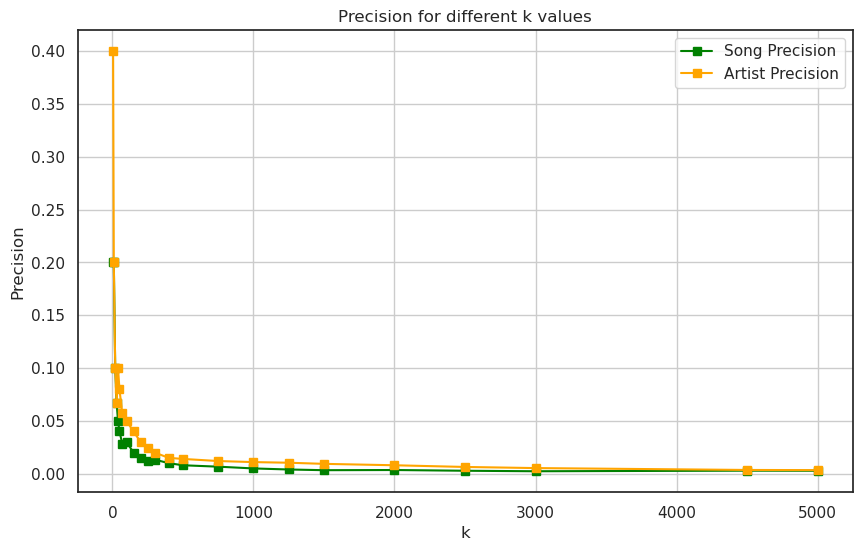

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(n_count_list, prec, label='Song Precision', marker='s', color='green')
plt.plot(n_count_list, prec_art, label='Artist Precision', marker='s', color='orange')
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('Precision for different k values')
plt.legend()
plt.grid(True)
plt.show()

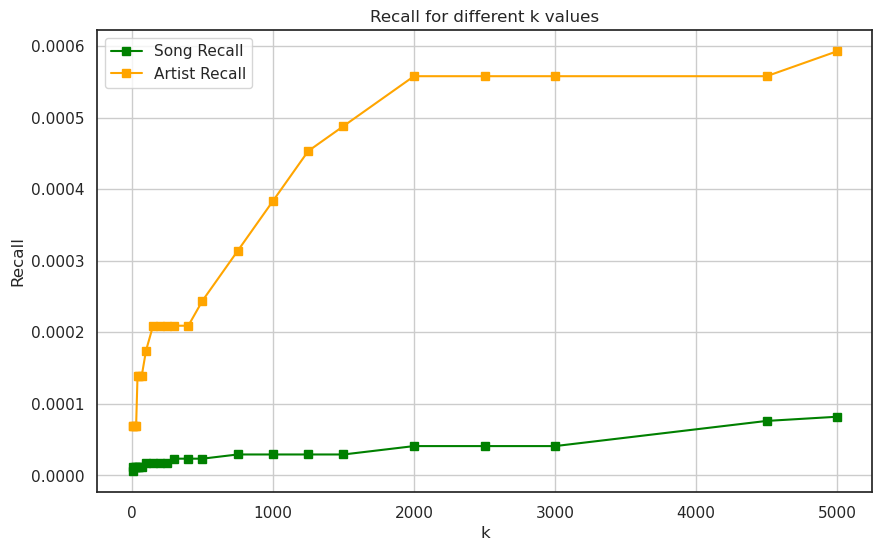

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(n_count_list, rec, label='Song Recall', marker='s', color='green')
plt.plot(n_count_list, rec_art, label='Artist Recall', marker='s', color='orange')
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('Recall for different k values')
plt.legend()
plt.grid(True)
plt.show()

# Выводы.
Конечно показатель получился достаточно низкий, но с другой стороны большой датасет и и 30 песен - это малая часть на фоне этого датасета. Но если взглянуть на рекомендации обычным глазом, получается вполне годно, в топе рекомендаций много песен и групп, которые я так же слушаю. 
В целом, получилось достаточно интересно.